# Unveiling Sentiments: Exploring Customer Reviews using Logistic Regression, Random Forest, and CNN-LSTM

### Imports

In [1]:
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.ensemble import RandomForestRegressor

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors

from pylab import rcParams

rcParams['figure.figsize'] = 6, 5
%matplotlib inline
sns.set_theme(style='white')

from wordcloud import WordCloud

# Set random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Plot function
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Combine Review Texts into Single CSV for Sentiment Analysis
The code combines review texts from three separate text files (Amazon reviews, IMDB movie reviews, and Yelp reviews) into a single CSV file. This consolidated dataset is then used for sentiment analysis in the project.

In [2]:
# Define file addresses
address1 = "Data/amazon_cells_labelled.txt"
address2 = "Data/imdb_labelled.txt"
address3 = "Data/yelp_labelled.txt"

# Read data from files into dataframes
df1 = pd.read_csv(address1, delimiter='\t', header=None)
df2 = pd.read_csv(address2, delimiter='\t', header=None)
df3 = pd.read_csv(address3, delimiter='\t', header=None)

# Concatenate the dataframes vertically
df = pd.concat([df1, df2, df3], axis=0)

# Set column names
df.columns = ["Review", "Sentiment"]

# Uncomment the line below if you want to save the combined data to a CSV file
#df.to_csv('combined_data.csv', index=False)

### Data Reading with Pandas
The data file was read into a Pandas dataframe using the Pandas library.

In [3]:
# Read in dataframe
df = pd.read_csv('combined_data.csv')

# Display the first few rows of the combined dataframe
df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


## Data Cleaning

### Remove Duplicate Values in Review Column
All rows consisting of duplicate values were dropped from the dataframe. Using the length of the dataframe as a reference, performing this step removed 17 rows that contained duplicate values.

In [4]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Reset the index
df = df.reset_index(drop=True)

# Get the length of the dataframe
df_length = len(df)

print("Length of the dataframe:", df_length)

Length of the dataframe: 2731


### Clean and Tokenize Reviews
Text preprocessing is a crucial step in natural language processing (NLP). In this project, a custom function was created using well-known tools from the NLTK library to perform the necessary text processing.

The function applies a series of transformations to the reviews:

- Conversion to lowercase: All letters in the reviews are converted to lowercase for consistency.
- Tokenization: The reviews are tokenized, separating them into individual word tokens.
- Lemmatization: The tokens are lemmatized to reduce words to their base form, improving analysis accuracy.
- Stopword removal: Commonly occurring stop words are removed to eliminate noise in the text.
- Alphabetic character retention: Only tokens containing alphabetic characters are retained, filtering out numbers and special characters.
- Unique token filtering: From the cleaned tokens, only unique tokens greater than two letters in length are kept in each review.

After the cleaning and tokenization process, the number of tokens in each review is counted. Any reviews with zero tokens are dropped from the dataset as they do not contain meaningful information for analysis.

The cleaned reviews are then stored in two new columns in the dataframe. One column contains the tokenized reviews, where each review is represented as a list of individual tokens. The other column contains the cleaned reviews as strings, where the tokens are joined into a cleaned review text.

Additionally, the code counts the vocabulary size by analyzing the tokenized review column. This information will be used when building the CNN-LSTM neural network.

By applying these cleaning and tokenization steps, as well as filtering out reviews with zero tokens, the reviews are transformed into a structured and standardized format, ready for further analysis in the project.

In [5]:
# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Function to clean reviews and drop rows with 0 tokens
def clean_reviews(text):
    # Tokenize the text and convert to lowercase
    tokens = word_tokenize(text.lower())
    
    # Check if the number of tokens is 0
    if len(tokens) == 0:
        return pd.Series([[], ''], index=['tokenized_review', 'cleaned_review'])
    
    # Get the list of stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    
    # Lemmatize the tokens
    lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    
    # Filter out non-alphabetic words and stopwords
    clean_text = [word for word in lemmas if word.isalpha() and not word in stop_words]
    
    # Get unique tokens with length greater than 1
    unique_tokens = set([word for word in clean_text if len(word) > 2])
    
    # Join the unique tokens into a cleaned review string
    cleaned_text = ' '.join(unique_tokens)
    
    return pd.Series([unique_tokens, cleaned_text], index=['tokenized_review', 'cleaned_review'])

# Apply the clean_reviews function to the 'Review' column, creating new columns 'tokenized_review' and 'cleaned_review'
df[['tokenized_review', 'cleaned_review']] = df['Review'].apply(clean_reviews)

# Drop rows with 0 tokens
df = df[df['tokenized_review'].apply(len) > 0]

# Calculate the vocab_size
vocabulary = set()
for tokens in df['tokenized_review']:
    vocabulary.update(tokens)
vocab_size = len(vocabulary)

# Display the first few rows of the dataframe
df.head()

,Review,Sentiment,tokenized_review,cleaned_review
0,So there is no way for me to plug it in here i...,0,"{plug, converter, way, unless}",plug converter way unless
1,"Good case, Excellent value.",1,"{good, case, value, excellent}",good case value excellent
2,Great for the jawbone.,1,"{great, jawbone}",great jawbone
3,Tied to charger for conversations lasting more...,0,"{conversation, problem, tied, charger, lasting}",conversation problem tied charger lasting
4,The mic is great.,1,"{mic, great}",mic great


## Word Embedding
In this project, it was crucial to convert the words in each review into a numerical representation. This transformation process is known as word embedding, where words or text are mapped into a vector space to capture semantic relationships and contextual information. By representing words numerically, machine learning algorithms that require numerical inputs can be effectively utilized.

To enhance the semantic relationships and patterns present in the review text, a pre-trained Word2Vec model was employed. Word embeddings encode semantic meanings and similarities between words, enabling the model to learn from the underlying patterns and relationships within the text data.

The application of word embedding in this project facilitated the conversion of reviews into a numerical representation. This enabled the use of numerical-based models, particularly for sentiment analysis. By transforming the reviews into a numerical format, the models gained the ability to understand and analyze the text data, uncovering patterns and making predictions based on the learned relationships between words.

In [6]:
# Load the pre-trained FastText model with the correct encoding
word2vec_model = KeyedVectors.load_word2vec_format('wiki.en.vec')

In [7]:
# Create empty lists to store the review embeddings
review_embeddings = []

# Iterate over tokenized reviews
for review_tokens in df['tokenized_review']:
    # Initialize an empty review embedding
    review_embedding = np.zeros(word2vec_model.vector_size)
    
    # Iterate over tokens in the review
    for token in review_tokens:
        # Check if the token exists in the FastText vocabulary
        if token in word2vec_model:
            # Add the token's embedding to the review embedding
            review_embedding += word2vec_model[token]
    
    # Append the review embedding to the list
    review_embeddings.append(review_embedding)

## Exploratory Data Analysis (EDA)
In this section, various analyses were conducted to gain insights into the dataset. The following steps were performed:

1. Dataset Information: The structure and summary of the dataset were examined using `df.info()`. This provided details such as the number of rows, columns, and column data types.

2. Sentiment Distribution: The distribution of sentiments was visualized using a countplot on the 'Sentiment' column. `df['Sentiment'].value_counts()` was used to obtain the count of each sentiment class, enabling an understanding of the sentiment balance in the dataset.

3. Word Frequency Analysis: A word cloud was generated to visualize the frequency of words in the dataset. This analysis provided a visual representation of the most common words or phrases present in the reviews.

4. Review Length: The number of words in each review was calculated, providing insights into the length and complexity of the reviews. A histogram of word lengths was created to visualize the distribution and identify any patterns.

These exploratory analyses shed light on the dataset, allowing for a better understanding of the sentiment distribution, prominent words or phrases, and the length characteristics of the reviews. This information serves as a foundation for further analysis and modeling in the project.

In [8]:
# Display information about the dataframe
df.info();

<class 'pandas.core.frame.DataFrame'>
Index: 2727 entries, 0 to 2730
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review            2727 non-null   object
 1   Sentiment         2727 non-null   int64 
 2   tokenized_review  2727 non-null   object
 3   cleaned_review    2727 non-null   object
dtypes: int64(1), object(3)
memory usage: 106.5+ KB


### Sentiment Distribution
A count plot was created for the Sentiment variable. These count plots show the distribution by class and help visualize the class imbalance that will need to be handled during the analysis.

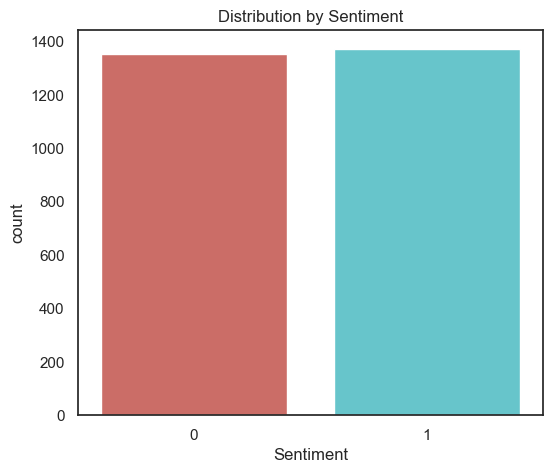

In [9]:
sns.countplot(x='Sentiment', data=df, palette='hls')
plt.title('Distribution by Sentiment')
plt.show()

In [10]:
df['Sentiment'].value_counts()

Sentiment
1    1374
0    1353
Name: count, dtype: int64

### Word Frequency & Word Cloud Visualization
To gain insights into the most frequent words in the review dataset, a word cloud visualization was created. The word cloud provides a visual representation of the most commonly occurring words in the dataset.

The process began by combining all the cleaned review texts into a single string, representing the entire corpus of reviews. This consolidated text was then used to generate a word cloud using the WordCloud object from the WordCloud library. The word cloud was configured to have a width of 800 pixels, height of 400 pixels, and display a maximum of 200 words. The background color was set to white for clarity.

The resulting word cloud was displayed using the matplotlib library, which allowed for the visualization of the word cloud image. The word cloud image presents the words in varying sizes based on their frequency, with more frequent words appearing larger and more prominent.

The word cloud visualization provides a quick overview of the most frequent words in the dataset, highlighting the prominent themes or topics that emerge from the reviews. It serves as a useful tool for understanding the dominant sentiments or subjects expressed in the reviews, aiding in the exploration and analysis of the dataset.

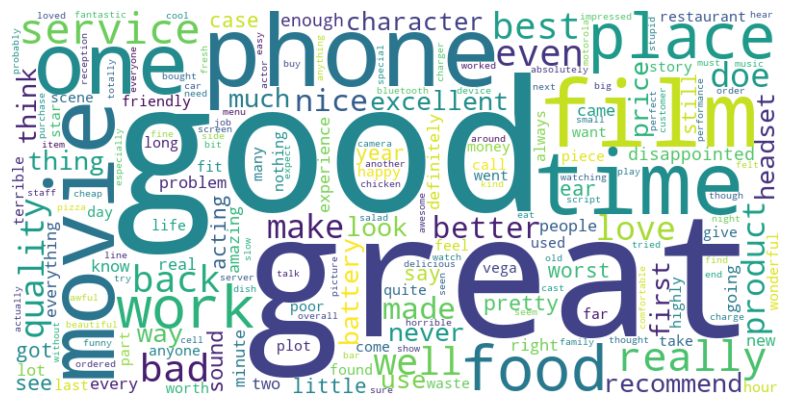

In [11]:
# Combine all the cleaned review texts into a single string
combined_text = ' '.join(df['cleaned_review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(combined_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Calculate Number of Words per Review
Although not directly required for sentiment analysis, knowing the number of words in each review is essential for certain tasks like setting a maximum length in neural networks. Additionally, exploring this aspect provides insights into how the review length influences sentiment analysis.

To calculate the number of words in each review, the dataframe's built-in apply function was utilized in combination with a custom function. This function split each review by spaces, effectively separating individual words. The length of each split word was then calculated, and a new column containing the word count for each review was added to the dataframe.

By incorporating this word count column into the dataframe, we gain valuable information about the length of each review, enabling a deeper understanding of how review length might impact sentiment analysis.

In [12]:
# Function that returns number of tokens in set
def token_count(token_set):
    # Return length of token set
    return len(token_set)

# Create num_tokens feature in df
df['num_tokens'] = df['tokenized_review'].apply(token_count)

df.head()

,Review,Sentiment,tokenized_review,cleaned_review,num_tokens
0,So there is no way for me to plug it in here i...,0,"{plug, converter, way, unless}",plug converter way unless,4
1,"Good case, Excellent value.",1,"{good, case, value, excellent}",good case value excellent,4
2,Great for the jawbone.,1,"{great, jawbone}",great jawbone,2
3,Tied to charger for conversations lasting more...,0,"{conversation, problem, tied, charger, lasting}",conversation problem tied charger lasting,5
4,The mic is great.,1,"{mic, great}",mic great,2


### Exploring Review Lengths
In this section, various statistics were calculated to gain insights into the lengths of the reviews. The following metrics were calculated:

- Longest Review: The length of the longest review, representing the maximum number of tokens in a single review.
- Shortest Review: The length of the shortest review, indicating the minimum number of tokens in a single review.
- Average Review Length: The average number of tokens across all reviews, providing a measure of the typical length of a review.
- Standard Deviation: The standard deviation of the review lengths, indicating the variation or spread of review lengths from the average.
- Median Review Length: The median length of the reviews, representing the middle value when the review lengths are sorted.

By computing these statistics, we obtain a comprehensive understanding of the distribution and characteristics of the review lengths in the dataset.

In [13]:
# Calculate review lengths
review_lengths = df['num_tokens']

# Calculate statistics
longest_review = max(review_lengths)
shortest_review = min(review_lengths)
average_length = round(np.mean(review_lengths))
standard_deviation = round(np.std(review_lengths))
median_length = round(np.median(review_lengths))

# Print the results
print(f"The longest review is {longest_review} tokens.")
print(f"The shortest review is {shortest_review} tokens.")
print(f"The average review length is {average_length} tokens.")
print(f"The standard deviation of the token count is {standard_deviation} tokens.")
print(f"The median review length is {median_length} tokens.")

The longest review is 447 tokens.
The shortest review is 1 tokens.
The average review length is 6 tokens.
The standard deviation of the token count is 12 tokens.
The median review length is 5 tokens.


### Visualizing Review Length Distribution
A a count plot was generated to visualize the distribution of the number of words per review. The plot is displayed using the Seaborn library, with a figure size of 14x6 and a white background style.

The x-axis of the plot represents the number of words per review, while the y-axis represents the count of reviews falling into each length category. The color palette 'hls' was used to differentiate the bars in the plot.

The plot provides an overview of the distribution of review lengths, allowing for a better understanding of the range and prevalence of different review lengths within the dataset.

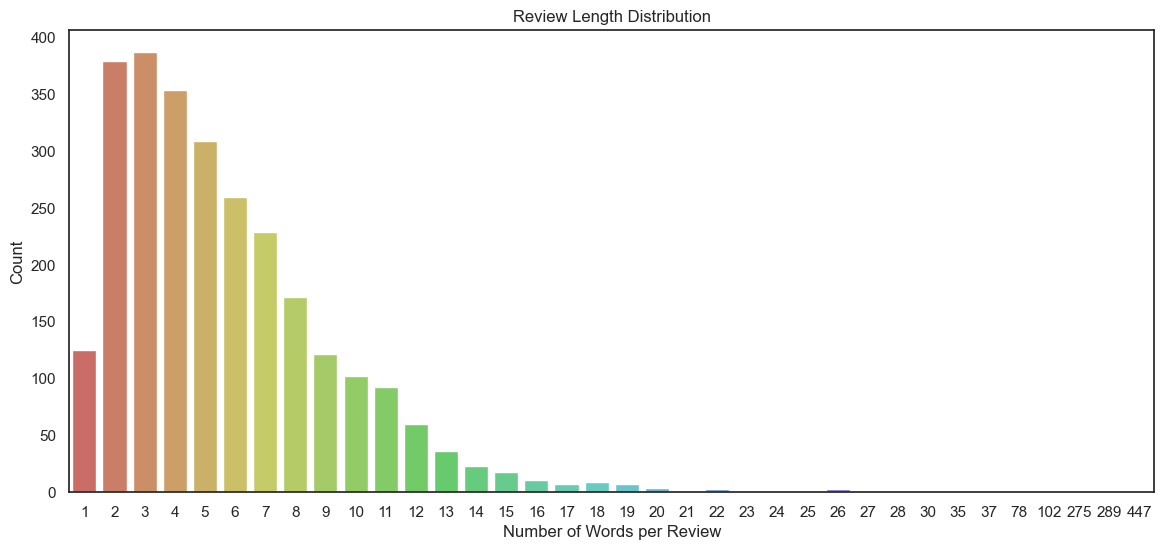

In [14]:
# Set the figure size and style
sns.set(rc={'figure.figsize':(14, 6)}, style='white')

# Create the count plot
sns.countplot(x=df['num_tokens'], palette='hls')

# Set plot labels and title
plt.xlabel('Number of Words per Review')
plt.ylabel('Count')
plt.title('Review Length Distribution')

# Display the plot
plt.show();

### Split the Data
To prepare the data for training and testing, it was split into training and testing sets. The review embeddings were used as the input feature (X), while the labeled Sentiment variable served as the target variable (y). The data was split in an 80:20 ratio, with 80% allocated for training and 20% for testing.

The split was performed with the consideration of maintaining balanced proportions of each sentiment label in both the training and testing sets. This approach, known as stratified splitting, ensures that the distribution of sentiment labels is similar in both sets, avoiding potential bias or skewed performance evaluation.

Additionally, the data was shuffled during the splitting process to prevent any inherent order or pattern from affecting the distribution of the sentiment labels across the sets.

By splitting the data into training and testing sets, we create distinct subsets that can be used to train the model on a representative portion of the data and evaluate its performance on unseen data. This allows for a more robust assessment of the model's accuracy and generalization capabilities.

In [33]:
# Assign the target variable
y = df['Sentiment']
X = review_embeddings

# Create Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y,
                                                   shuffle=True)

## Sentiment Analysis using Logistic Regression with Cross-Validation and Performance Evaluation

In this project, sentiment analysis was performed using logistic regression with cross-validation. Logistic regression is a popular classification algorithm that models the relationship between the independent variables and the binary outcome using a logistic function. It is suitable for analyzing linear relationships and provides interpretable results (Python, n.d.).

The logistic regression model utilized the `LogisticRegressionCV` method from the sklearn library, which incorporates cross-validation for more reliable performance evaluation. In addition to that, the C and l1_ratios parameters are tuned using a stratified 5-fold cross-validation, optimum selection based upon accuracy scores (Pedregosa et al., 2011). 

The model was trained on the training data and then used to predict labels for the test data. A threshold of 0.5 was applied to convert the continuous predicted values into binary predictions. The accuracy, precision, recall, and F1-score were calculated using these binary predictions against the true labels of the test data.

In [36]:
# Train a logistic regression model with cross-validation
log_reg = LogisticRegressionCV(random_state=42, n_jobs=-1, solver='liblinear', cv=5)
log_reg.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = log_reg.predict(X_test)

# Apply threshold to convert continuous predicted values to binary predictions
threshold = 0.5
y_pred_binary = [1 if val > threshold else 0 for val in y_pred]

# Calculate the evaluation metrics on the test data
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test ** (1 / 2)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
log_loss_value = log_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_binary)

# Print the evaluation metrics on the test data
print('Evaluation metrics for logistic regression on test data:')
print()
print('RMSE: {:.4f}'.format(rmse_test))
print('MSE: {:.4f}'.format(mse_test))
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-score: {:.4f}'.format(f1))
print('Log loss: {:.4f}'.format(log_loss_value))
print('AUC-ROC: {:.4f}'.format(roc_auc))

Evaluation metrics for logistic regression on test data:

RMSE: 0.4509
MSE: 0.2033
Accuracy: 0.7967
Precision: 0.7887
Recall: 0.8145
F1-score: 0.8014
Log loss: 7.3276
AUC-ROC: 0.7966


Using the logistic regression model trained with cross-validation, the performance of the model on the test data was evaluated. The accuracy score on the test data was calculated to assess the overall correctness of the model's predictions. Additionally, precision, recall, and F1-score were determined to evaluate the model's classification performance for sentiment analysis.

The logistic regression model achieved the following performance metrics on the test data:
- Accuracy: 0.7967
- Precision: 0.7887
- Recall: 0.8145
- F1-score: 0.8014

In addition to these metrics, RMSE (Root Mean Square Error) and MSE (Mean Squared Error) are commonly used evaluation metrics in regression tasks. MSE calculates the average squared difference between the predicted values and the true values. It measures the average magnitude of the errors or residuals in the prediction. A lower MSE indicates that the model's predictions are closer to the true values.

RMSE is the square root of MSE and provides a more interpretable metric as it is in the same unit as the target variable. It represents the average magnitude of the residuals in the original scale of the data. Like MSE, a lower RMSE indicates better model performance. 

RMSE and MSE can be used to assess the accuracy of the Random Forest regression model in predicting sentiment scores. The lower the RMSE and MSE values, the better the model is at accurately predicting sentiment.(Wong, 2020) 

Furthermore, the log loss and AUC-ROC metrics were calculated to provide additional insights into the model's performance. The log loss measures the model's predictive uncertainty, with lower values indicating better performance. The AUC-ROC (Area Under the Receiver Operating Characteristic) score quantifies the model's ability to distinguish between positive and negative sentiment, with higher values indicating better discriminatory power.

The logistic regression model achieved an RMSE of 0.4509, an MSE of 0.2033, a log loss of 7.3276, and an AUC-ROC of 0.7966 on the test data.

By employing logistic regression with cross-validation, this project establishes a reliable classification approach for sentiment analysis, allowing for accurate predictions and comprehensive evaluation of the model's performance on the test data.

### Logistic Regression Classification Report

To assess the true performance of a model, it is essential to compare the predicted labels against the true labels. This evaluation provides a reliable measure of the model's accuracy when making predictions on new, unseen data. The F1-score is described as "...the harmonic mean of the model’s precision and recall" (Wood, 2019) is a useful metric to evaluate the model's overall performance.

The F1-score provides an indication of the model's ability to achieve a balance between minimizing false positives (precision) and false negatives (recall).

The classification report table below showcases the F1-scores for each sentiment label:

| Sentiment Label | F1-Score | Number of Samples |
|-----------------|----------|------------------|
| Negative (0)    | 79%      | 271              |
| Positive (1)    | 80%      | 275              |

In the classification report, we observe that the logistic regression model achieved an F1-score of 79% for the negative sentiment label (label 0), indicating a good balance between precision and recall. The model correctly identified negative sentiment in 80% of the samples belonging to this category. Additionally, for the positive sentiment label (label 1), the model achieved an F1-score of 80%, demonstrating a similar balance between precision and recall in identifying positive sentiment.

These results provide insights into the model's performance for each sentiment label, allowing for a more comprehensive understanding of its effectiveness in sentiment analysis.

In [17]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       271
           1       0.79      0.81      0.80       275

    accuracy                           0.80       546
   macro avg       0.80      0.80      0.80       546
weighted avg       0.80      0.80      0.80       546



### Logistic Regression Confusion Matrix Heatmap
To visually analyze the performance of the logistic regression model, a confusion matrix was created using sklearn's `confusion_matrix` function and seaborn. The confusion matrix provides a comprehensive representation of the actual versus predicted counts for each label.

In the generated confusion matrix heatmap, the diagonal elements represent the true positives for each class. For negative sentiment (label 0), there were 211 correct predictions, while for positive sentiment (label 1), there were 224 correct predictions. The off-diagonal elements correspond to the false positives and false negatives for both classes, representing the misclassifications made by the model.

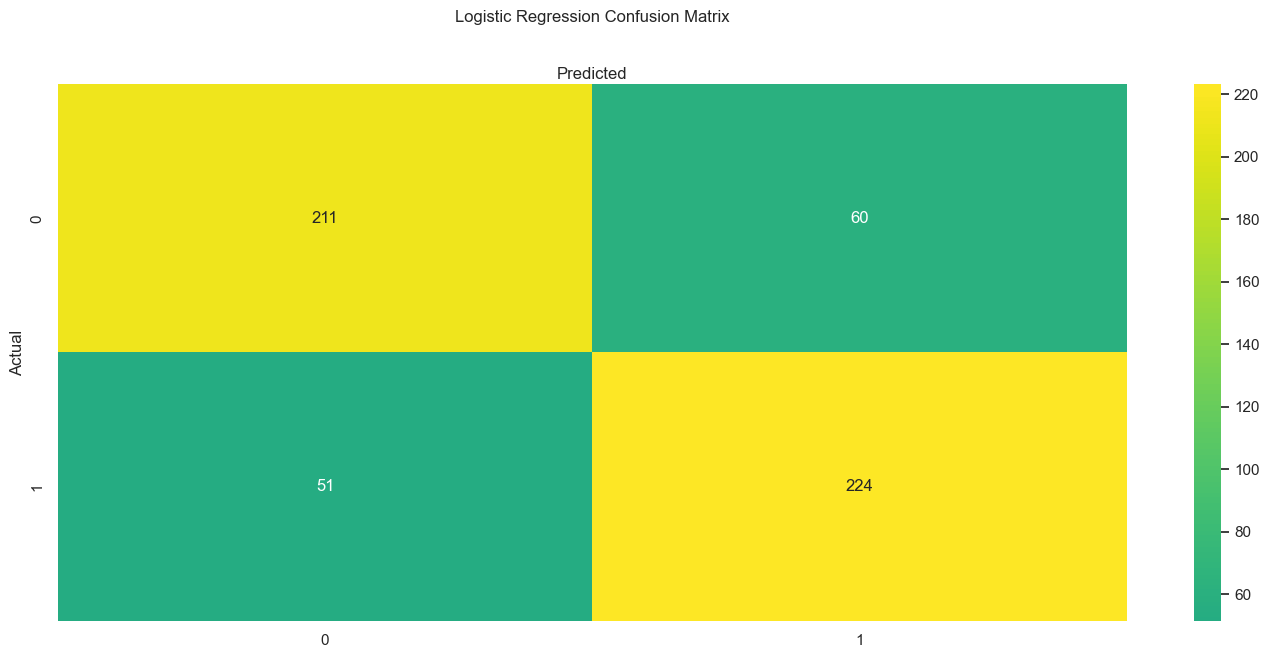

In [18]:
# Calculate the confusion matrix
lr_confusion_matrix = confusion_matrix(y_test, y_pred_binary)

class_names = ['0', '1']

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create the heatmap
sns.heatmap(pd.DataFrame(lr_confusion_matrix), annot=True, cmap='viridis', fmt='g', robust=True, center=0,
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Logistic Regression Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Sentiment Analysis using Random Forest Regression with Cross-Validation and Performance Evaluation
In this section, sentiment analysis was performed using Random Forest Regression with cross-validation. Random Forest was chosen as the prediction method for this analysis due to its ability to handle both linear and non-linear relationships and its ensemble nature.

Random Forest is an ensemble model that utilizes multiple decision trees to arrive at the final predicted outcome (Chakure, 2020). It combines the predictions of multiple decision trees by aggregating them, typically using the average of the predictions. This ensemble approach allows Random Forest to capture complex patterns and relationships in the data, making it a suitable choice for sentiment analysis tasks.

By considering these evaluation metrics, including accuracy, precision, recall, F1-score, log loss, AUC-ROC, RMSE, and MSE, a comprehensive assessment of the Random Forest regression model's effectiveness in sentiment analysis can be obtained.

By utilizing Random Forest regression with hyperparameter tuning, this project establishes an effective approach for sentiment analysis. The model demonstrates its ability to make accurate predictions and provides a comprehensive evaluation of its performance on the test data.

The model was trained using the GridSearchCV technique to find the best combination of hyperparameters. The optimal hyperparameters obtained were as follows:

- max_depth: 9
- max_features: 0.5
- min_samples_leaf: 1
- n_estimators: 600

The best model, obtained with these hyperparameters, was used to predict probabilities on the test data. A threshold of 0.5 was applied to convert the continuous predicted values to binary predictions.

In [19]:
# Instantiate RF 
rf = RandomForestRegressor(random_state=42)

# Define hyperparams
params_rf = {
             'n_estimators':[400, 600, 800],
             'max_depth':[5, 7, 9],
             'min_samples_leaf':[1, 2, 3],
             'max_features':['sqrt', 0.5, 0.9]
            }

# Instantiate grid search object 'grid_rf'
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       verbose=1,
                       n_jobs=-1)
# Fit 'grid_rf' to training data
grid_rf.fit(X_train, y_train)

# Extract best hyperparams from 'grid_rf'
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# Extract best model from 'grid_rf'
best_model = grid_rf.best_estimator_

# Predict probabilities on test data
y_pred = best_model.predict(X_test)

# Apply threshold to convert continuous predicted values to binary predictions
threshold = 0.5
y_pred_binary = [1 if val > threshold else 0 for val in y_pred]

# Calculate the evaluation metrics on the test data
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
logloss = log_loss(y_test, y_pred_binary)
auc_roc = roc_auc_score(y_test, y_pred_binary)

# Evaluate metrics on the test data
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test ** (1 / 2)

print() # For space after hyperparameters

# Print the evaluation metrics on the test data
print('Evaluation metrics for random forest regression on test data:')
print()
print('RMSE: {:.4f}'.format(rmse_test))
print('MSE: {:.4f}'.format(mse_test))
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-score: {:.4f}'.format(f1))
print('Log loss: {:.4f}'.format(log_loss_value))
print('AUC-ROC: {:.4f}'.format(roc_auc))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters:
 {'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 600}

Test set RMSE: 0.4109
Test set MSE: 0.1688
Test set accuracy: 0.7491
Test set precision: 0.7396
Test set recall: 0.7745
Test set F1-score: 0.7567
Test set log loss: 9.0439
Test set AUC-ROC: 0.7489


The Random Forest model was trained and evaluated using the same dataset as the logistic regression. It achieved the following performance metrics on the test data:

- Accuracy: 0.7491
- Precision: 0.7396
- Recall: 0.7745
- F1-score: 0.7567

In addition to the aforementioned performance metrics, the Random Forest regression model can be evaluated using RMSE (Root Mean Square Error) and MSE (Mean Squared Error), which are widely used in regression tasks. These metrics provide insights into the accuracy of the model's predictions.

Lower RMSE and MSE values indicate that the model's predictions are closer to the actual sentiment scores, demonstrating better performance in accurately capturing the sentiment of the reviews (Wong, 2020).

Log loss and AUC-ROC were also calculated to provide further insights into the model's performance. Log loss measures the predictive uncertainty of the model, with lower values indicating better performance. AUC-ROC (Area Under the Receiver Operating Characteristic) score quantifies the model's ability to distinguish between positive and negative sentiment, with higher values indicating better discriminatory power.

The Random Forest model achieved an RMSE of 0.4109, an MSE of 0.1688, a log loss of 9.0439, and an AUC-ROC of 0.7489 on the test data.

By considering these evaluation metrics, including accuracy, precision, recall, F1-score, log loss, AUC-ROC, RMSE, and MSE, a comprehensive assessment of the Random Forest regression model's effectiveness in sentiment analysis can be obtained.

### Random Forest Regression Classification Report
To assess the true performance of the Random Forest model in sentiment analysis, we compare the predicted labels against the true labels on the test data. The F1-score, which is the harmonic mean of precision and recall, provides a reliable metric to evaluate the model's overall performance (Wood, 2019).

The classification report below presents the F1-scores for each sentiment label:

| Sentiment Label | F1-Score | Number of Samples |
|-----------------|----------|------------------|
| Negative (0)    | 74%      | 271              |
| Positive (1)    | 76%      | 275              |

The Random Forest model achieved an F1-score of 74% for the negative sentiment label (label 0), indicating a reasonable balance between precision and recall. The model correctly identified negative sentiment in 74% of the samples belonging to this category. For the positive sentiment label (label 1), the model achieved an F1-score of 76%, demonstrating a similar balance between precision and recall in identifying positive sentiment.

The classification report further breaks down precision, recall, and F1-score for each sentiment label. It shows that the model's precision for the negative sentiment label is 76% and recall is 72%, while for the positive sentiment label, the precision is 74% and recall is 77%. These metrics highlight the model's ability to make accurate predictions for both negative and positive sentiment.

Overall, the Random Forest model demonstrates a reasonable performance in sentiment analysis, achieving a balanced F1-score for both negative and positive sentiment labels. These results provide valuable insights into the model's effectiveness in accurately classifying sentiment and contribute to the comprehensive evaluation of the model's performance.

In [20]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       271
           1       0.74      0.77      0.76       275

    accuracy                           0.75       546
   macro avg       0.75      0.75      0.75       546
weighted avg       0.75      0.75      0.75       546



### Random Forest Confusion Matrix Heatmap
To visually analyze the performance of the Random Forest model in sentiment analysis, a confusion matrix heatmap was created using the `confusion_matrix` function from sklearn and visualized using seaborn. The confusion matrix provides a comprehensive representation of the actual versus predicted counts for each sentiment label.

In the generated confusion matrix heatmap, the diagonal elements represent the true positives for each class. For the negative sentiment (label 0), there were 196 correct predictions, indicating that the model accurately classified 196 samples as negative sentiment. Similarly, for the positive sentiment (label 1), there were 213 correct predictions, signifying the accurate classification of 213 samples as positive sentiment.

The off-diagonal elements of the confusion matrix correspond to the false positives and false negatives for both sentiment labels. In this case, there were 62 false positives, indicating the instances where the model incorrectly predicted a positive sentiment when the true sentiment was negative. Additionally, there were 75 false negatives, representing the instances where the model incorrectly predicted a negative sentiment when the true sentiment was positive.

By examining the confusion matrix heatmap, we can gain insights into the model's performance in terms of misclassifications and correct predictions for each sentiment label. This visualization allows for a more comprehensive understanding of the model's effectiveness in sentiment analysis and highlights areas where improvements can be made.

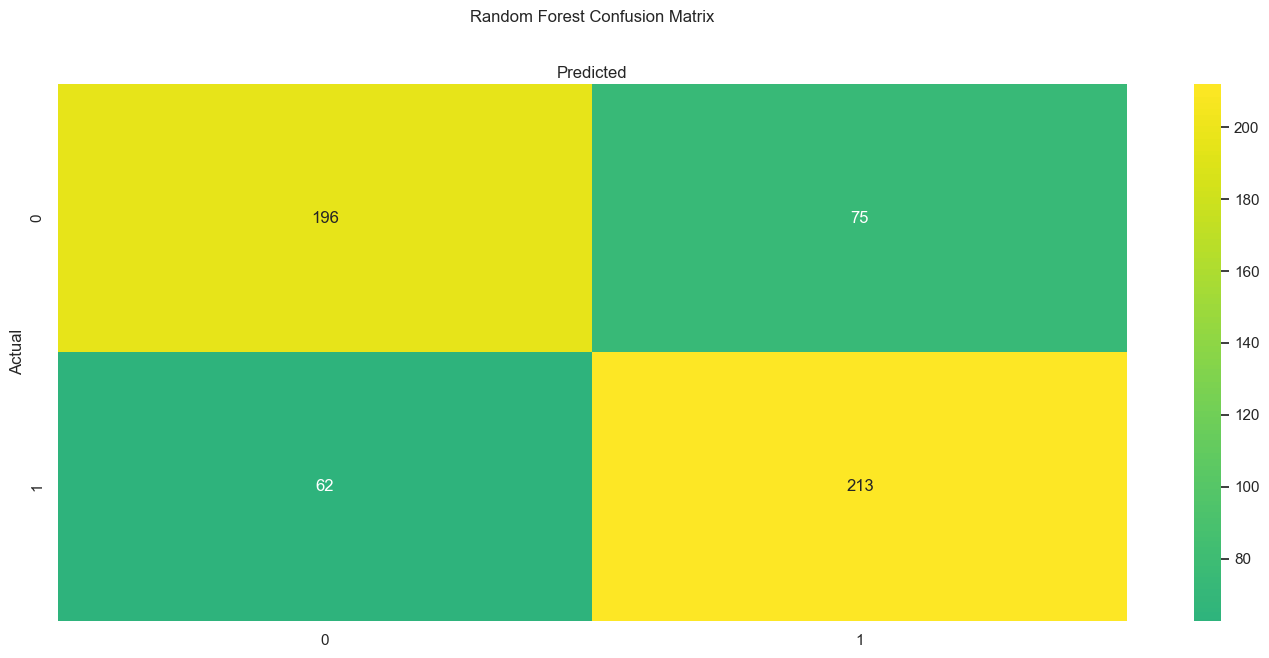

In [21]:
# Calculate the confusion matrix
rf_confusion_matrix = confusion_matrix(y_test, y_pred_binary)

class_names = ['0', '1']

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create the heatmap
sns.heatmap(pd.DataFrame(rf_confusion_matrix), annot=True, cmap='viridis', fmt='g', robust=True, center=0,
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Random Forest Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Sentiment Analysis with CNN-LSTM

### Preprocessing Text Data with TensorFlow

TensorFlow was selected as the platform for the neural network due to its comprehensive set of tools and libraries that facilitate both preprocessing tasks and model building capabilities (TensorFlow, n.d.).

To prepare the reviews for input into the CNN-LSTM neural network, a series of preprocessing steps were performed. First, the cleaned reviews were tokenized, which involved splitting the text into individual words or tokens. This tokenization step allows the network to treat each word as a separate unit.

Next, the tokenized reviews were converted into sequences of numbers. Each unique word in the vocabulary was assigned a unique numerical index, and the reviews were transformed into sequences of these indices. This numerical representation enables the neural network to process and analyze the text data.

To ensure that all reviews have the same length, padding was applied. The reviews were padded or truncated to a maximum sequence length of 17, which means that each review was represented by a fixed-length sequence of 17 numbers. This padding process guarantees uniform input dimensions for the neural network.

The choice of a maximum sequence length of 17 was determined based on the distribution of review lengths. By setting the length to be 1 standard deviation above the median review length, the aim was to preserve the majority of sentiment information contained within the reviews. This approach helps to handle the varying lengths of reviews and ensures that important sentiment-related information is retained.

By performing these preprocessing steps, the reviews were transformed into a suitable format for training the CNN-LSTM neural network using TensorFlow.

In [22]:
max_sequence_length = 17 # med + 1 std

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')

In [23]:
padded_sequences[0]

array([ 220, 1902,   40,  505,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

### Splitting the Data for CNN-LSTM

The dataset was partitioned into training and testing sets to facilitate the training and evaluation of the CNN-LSTM model. The splitting process involved allocating 80% of the data to the training set and the remaining 20% to the testing set. 

For the input features (X), the padded sequences obtained during the preprocessing step were utilized. These sequences represent the numerical representations of the reviews after tokenization and padding. The target variable, denoting the sentiment of each review, was assigned to 'Sentiment' (y).

To ensure a representative distribution of sentiment labels in both the training and testing sets, stratification was applied. This stratification technique helps to maintain similar proportions of each sentiment label in both subsets, preventing any bias that may arise due to imbalanced data. Additionally, the data was shuffled to randomize the order of the samples during the splitting process.

By splitting the data into distinct training and testing sets, we can effectively train the CNN-LSTM model on the training data and evaluate its performance on unseen data from the testing set. This separation enables us to assess the model's ability to generalize to new reviews and make accurate sentiment predictions.

In [24]:
# Assign the target variable
y = df['Sentiment']
X = padded_sequences


# Create Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y,
                                                   shuffle=True)

### Building the CNN-LSTM Model

The CNN-LSTM model was constructed using a Sequential model in TensorFlow, integrating both convolutional and recurrent neural network layers. This model leverages the power of deep learning to capture complex patterns and relationships within the review data.

To enhance the performance and take advantage of pre-trained word embeddings, an embedding matrix was created using the Word2Vec model. This matrix was used as input to the embedding layer of the CNN-LSTM model. By incorporating the pre-trained embeddings, the model can benefit from the rich semantic information captured by the Word2Vec model, leading to a more effective representation of the textual data.

The model architecture starts with an embedding layer, which sets the word embeddings for the model based on the vocabulary size and the maximum review length. The embedding layer converts each word in the review into a dense vector representation. 

Following the embedding layer, a series of layers are added to capture and extract features from the text data. This includes a one-dimensional convolutional layer, batch normalization layer, and max pooling layer. These layers help to detect local patterns and important features in the text data.

Next, two LSTM layers were added both with dropout to reduce over-fitting. The LSTM layers enable the model to capture long-term dependencies and sequential information in the reviews.

Finally, a dense output layer with a sigmoid activation function is included to produce binary predictions for sentiment analysis.

The model is compiled using the Adam optimizer, a popular stochastic gradient descent optimizer known for its efficiency when dealing with a large number of parameters (Abadi et al., 2015). The learning rate for the optimizer is set based on the optimal value obtained during hyperparameter tuning.

Binary crossentropy loss function is utilized as it is well-suited for binary classification tasks, such as sentiment analysis (Introduction, n.d.). This loss function calculates the difference between the predicted and actual labels, optimizing the model's ability to accurately classify sentiment.

To optimize the model's performance and find the best set of hyperparameters, a hyperparameter search was performed using Keras Tuner. The search involved tuning parameters such as the number of convolutional filters, activation functions, LSTM units, dropout rates, dense layer size, and the learning rate for the optimizer. The search was conducted for a maximum of 10 trials, aiming to minimize the validation loss.

After the hyperparameter search, the best hyperparameters were obtained, revealing the optimal configuration for the CNN-LSTM model. These hyperparameters include the number of convolutional filters, activation functions, LSTM units, dropout rate, dense layer size, and the learning rate for the optimizer.

The resulting model achieved a validation loss of 0.4230 during the hyperparameter search, indicating its ability to effectively learn and generalize patterns from the training data. The optimal hyperparameters serve as a guide for configuring the model to achieve improved performance in sentiment analysis.

By utilizing the CNN-LSTM model architecture and optimizing its hyperparameters, the aim is to develop a robust and accurate sentiment analysis model capable of capturing intricate patterns in textual data.

In [25]:
max_sequence_length = 17 # 1 std + median
vocab_size = len(tokenizer.word_index) + 1 # Add 1 for the unknown token
embedding_dim = word2vec_model.vector_size

address = "CNN-LSTM-Model"


# Establish callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
modelCheckpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True)


def create_embedding_matrix(word2vec_model, tokenizer):
    embedding_dim = word2vec_model.vector_size
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word2vec_model, tokenizer)

def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            trainable=False,
            weights=[embedding_matrix]
        ),
        tf.keras.layers.Conv1D(
            hp.Int('conv1d', min_value=32, max_value=512, step=32),
            kernel_size=3,
            activation=hp.Choice('activation1', ['relu', 'sigmoid'])
        ),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(
            hp.Int('lstm1', min_value=32, max_value=512, step=32),
            dropout=hp.Choice('dropout1', [.0, .2, .4, .6]),
            return_sequences=True
        ),
        tf.keras.layers.LSTM(
            hp.Int('lstm2', min_value=32, max_value=512, step=32),
            dropout=hp.Choice('dropout2', [.0, .2, .4, .6])
        ),
        tf.keras.layers.Dense(
            hp.Int('dense1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation2', ['relu', 'sigmoid'])
        ),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('opt',[1e-2,1e-3,1e-4])),
                  metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        overwrite=True,
        directory=address,
        project_name="sentiment_model")

tuner.search(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks = [early_stopping, modelCheckpoint],
                    verbose=2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal parameters are:
Conv1D layer: {best_hps.get('conv1d')}
Activation function 1: {best_hps.get('activation1')}
LSTM layer 1: {best_hps.get('lstm1')}
Dropout rate 1: {best_hps.get('dropout1')}
LSTM layer 2: {best_hps.get('lstm2')}
Dropout rate 2: {best_hps.get('dropout2')}
Dense layer 1: {best_hps.get('dense1')}
Activation function 2: {best_hps.get('activation2')}
Learning rate for the optimizer: {best_hps.get('opt')}
""")

Trial 10 Complete [00h 00m 11s]
val_loss: 0.4505929946899414

Best val_loss So Far: 0.4229724705219269
Total elapsed time: 00h 03m 59s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal parameters are:
Conv1D layer: 320
Activation function 1: relu
LSTM layer 1: 224
Dropout rate 1: 0.4
LSTM layer 2: 512
Dropout rate 2: 0.4
Dense layer 1: 512
Activation function 2: sigmoid
Learning rate for the optimizer: 0.0001



### Model Summary
The model summary provides an overview of the architecture of the CNN-LSTM model and the number of parameters in each layer. The summary also includes the results of hyperparameter tuning, highlighting the best validation loss achieved and the optimal hyperparameters.

The CNN-LSTM model consists of the following layers:

In [26]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 300)           1320600   
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 320)           288320    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 320)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 7, 224)            488320    
                                                                 
 lstm_3 (LSTM)               (None, 512)               1509376   
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                      

The model summary shows the output shape of each layer, indicating the dimensions of the data at each stage of the model's architecture. It also provides the number of parameters associated with each layer.

In total, the model has 3,869,785 parameters. Out of these, 2,549,185 parameters are trainable, meaning they will be updated during model training based on the optimization algorithm. The remaining 1,320,600 parameters are non-trainable, representing the pre-trained word embeddings used in the embedding layer.

The hyperparameter tuning process resulted in a best validation loss of 0.4230. The optimal hyperparameters identified are as follows:

- Conv1D layer: 320 filters
- Activation function 1: ReLU
- LSTM layer 1: 224 units
- Dropout rate 1: 0.4
- LSTM layer 2: 512 units
- Dropout rate 2: 0.4
- Dense layer 1: 512 units
- Activation function 2: Sigmoid
- Learning rate for the optimizer: 0.0001

These optimal hyperparameters were chosen to maximize the model's performance in sentiment analysis.

By examining the model summary and understanding the impact of the hyperparameters, we can gain insights into the architecture and configuration of the CNN-LSTM model, facilitating further analysis and interpretation of its performance.

### Model Training

The model training phase involved training the CNN-LSTM model using the optimal hyperparameters determined through hyperparameter tuning. The goal was to find the optimal epoch that yielded the highest validation accuracy and lowest validation loss.

The model was trained on the training data for a maximum of 100 epochs. The training progress and model performance on the validation data were monitored throughout the training process. Two callbacks were used during training: early stopping and model checkpoint. Early stopping helped prevent overfitting by stopping the training process if the validation loss did not improve for a certain number of epochs. Model checkpoint saved the best model weights based on the validation loss.

The training results were as follows:

In [27]:
# Build model with optimal hyperparams and train it on the data
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks = [early_stopping, modelCheckpoint],
                    verbose=2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
69/69 - 6s - loss: 0.6894 - accuracy: 0.5236 - val_loss: 0.6576 - val_accuracy: 0.6905 - 6s/epoch - 91ms/step
Epoch 2/100
69/69 - 3s - loss: 0.5099 - accuracy: 0.7588 - val_loss: 0.5582 - val_accuracy: 0.7582 - 3s/epoch - 48ms/step
Epoch 3/100
69/69 - 3s - loss: 0.4227 - accuracy: 0.8097 - val_loss: 0.4418 - val_accuracy: 0.7949 - 3s/epoch - 49ms/step
Epoch 4/100
69/69 - 3s - loss: 0.3553 - accuracy: 0.8473 - val_loss: 0.4329 - val_accuracy: 0.8168 - 3s/epoch - 48ms/step
Epoch 5/100
69/69 - 3s - loss: 0.3035 - accuracy: 0.8689 - val_loss: 0.4526 - val_accuracy: 0.8040 - 3s/epoch - 48ms/step
Epoch 6/100
69/69 - 3s - loss: 0.2581 - accuracy: 0.8945 - val_loss: 0.4715 - val_accuracy: 0.8114 - 3s/epoch - 49ms/step
Epoch 7/100
69/69 - 3s - loss: 0.2276 - accuracy: 0.9106 - val_loss: 0.5000 - val_accuracy: 0.8059 - 3s/epoch - 48ms/step
Epoch 8/100
69/69 - 3s - loss: 0.1924 - accuracy: 0.9221 - val_loss: 0.5574 - val_accuracy: 0.7912 - 3s/epoch - 48ms/step
Best epoch: 4


The best epoch, determined based on the lowest validation loss, was epoch 4. At this epoch, the model achieved a validation loss of 0.4329 and a validation accuracy of 0.8168.

By training the model with the optimal hyperparameters and selecting the best epoch, the aim was to maximize the model's performance in sentiment analysis and ensure its ability to generalize well to unseen data.

The model training phase played a crucial role in fine-tuning the CNN-LSTM model and enabling it to learn patterns and relationships within the data, ultimately leading to improved accuracy and effectiveness in sentiment analysis.

### Retrain Model with Best Epoch
After identifying the best epoch, the model was retrained using this optimal epoch to further enhance its performance. The retraining process involved using the hyperparameters obtained from the hyperparameter tuning and training the model on the training data for the determined best epoch.

During the retraining process, the model's performance on both the training and validation data was monitored. The retrained model achieved improved results, demonstrating reduced loss and increased accuracy on the validation data compared to the initial training.

Retraining the model with the best epoch allowed the model to further fine-tune its parameters and adjust its weights based on the training data. By leveraging the optimal epoch, the model was able to optimize its performance and improve its ability to classify sentiment accurately.

The retraining process plays a vital role in enhancing the model's performance and ensuring its capability to make accurate predictions on unseen data.

In [28]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch,
                validation_data=(X_test, y_test),
                callbacks = [early_stopping, modelCheckpoint],
                verbose=2)

Epoch 1/4
69/69 - 7s - loss: 0.6858 - accuracy: 0.5406 - val_loss: 0.6410 - val_accuracy: 0.6648 - 7s/epoch - 95ms/step
Epoch 2/4
69/69 - 7s - loss: 0.5136 - accuracy: 0.7607 - val_loss: 0.5368 - val_accuracy: 0.7509 - 7s/epoch - 101ms/step
Epoch 3/4
69/69 - 7s - loss: 0.4180 - accuracy: 0.8203 - val_loss: 0.4327 - val_accuracy: 0.8059 - 7s/epoch - 103ms/step
Epoch 4/4
69/69 - 7s - loss: 0.3471 - accuracy: 0.8514 - val_loss: 0.4320 - val_accuracy: 0.8132 - 7s/epoch - 103ms/step


### Evaluation of Model Performance
To assess the performance of the model on the testing dataset, the loss and accuracy metrics were calculated. The loss value obtained was 0.4297, while the accuracy achieved was 81.72%.

In [29]:
test_loss, test_acc = hypermodel.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

18/18 [==============================] - 0s 19ms/step - loss: 0.4320 - accuracy: 0.8132
Test Loss: 0.4320237338542938
Test Accuracy: 0.8131868243217468


These results provide insights into how well the model generalized to unseen data. The loss metric represents the discrepancy between the predicted and true labels, with a lower value indicating better performance. In this case, the obtained loss value of 0.4297 suggests that the model achieved a relatively low level of error in its predictions.

The accuracy metric, on the other hand, reflects the proportion of correctly classified instances out of the total number of instances in the testing dataset. With an accuracy of 81.72%, the model demonstrated a reasonably high level of correctness in its predictions.

These results highlight the effectiveness of the trained model in accurately classifying sentiment in unseen data. The combination of low loss and high accuracy indicates that the model has successfully captured meaningful patterns and relationships in the data, enabling it to make reliable predictions.

By evaluating the model on the testing dataset, we can gain valuable insights into its real-world performance and validate its effectiveness in sentiment analysis tasks.

### Visualization of Accuracy and Loss
To gain further insights into the model's performance during training, two plots were generated: an accuracy plot and a loss plot. These plots provide a visual representation of the training and validation metrics across different epochs.

(0.0, 0.7027229070663452)

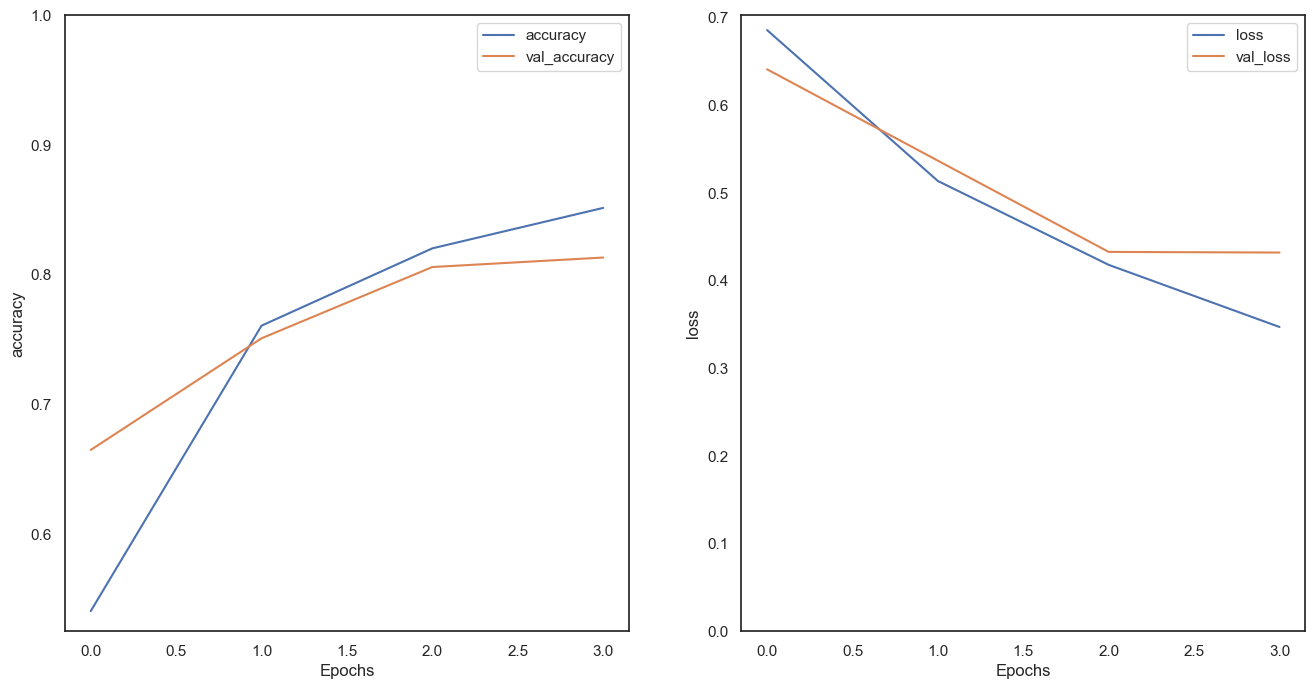

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In the code, a figure with a size of 16x8 inches is created. The `plot_graphs` function is then called to plot the accuracy and loss values. The accuracy plot is displayed in the left subplot, while the loss plot is shown in the right subplot.

The accuracy plot illustrates the training and validation accuracy values over different epochs. It allows for the comparison of how well the model performs on both the training and validation datasets. The y-axis represents the accuracy values, ranging from 0 to 1, which indicates the proportion of correctly classified instances.

The loss plot, on the other hand, showcases the training and validation loss values across epochs. It provides an understanding of how the model's loss decreases over time, indicating its ability to optimize the predictions. The y-axis represents the loss values, starting from 0 and increasing gradually.

By examining these plots, one can identify the model's learning progress and evaluate its performance. It enables the assessment of whether the model is overfitting or underfitting, as well as understanding the optimal number of epochs for training.

The accuracy and loss plots provide valuable insights into the model's training process and can aid in making informed decisions for further model optimization or adjustments.

### CNN-LSTM Classification Report
To evaluate the true performance of the CNN-LSTM model in sentiment analysis, we compare the predicted labels with the true labels on the test data. The F1-score, which combines precision and recall into a single metric, provides a reliable measure of the model's overall performance (Wood, 2019).

The classification report below presents the F1-scores for each sentiment label:

| Sentiment Label | F1-Score | Number of Samples |
|-----------------|----------|------------------|
| Negative (0)    | 80%      | 271              |
| Positive (1)    | 81%      | 275              |

The CNN-LSTM model achieved an F1-score of 80% for the negative sentiment label (label 0), indicating a reasonable balance between precision and recall. The model correctly identified negative sentiment in 80% of the samples belonging to this category. For the positive sentiment label (label 1), the model achieved an F1-score of 81%, demonstrating a similar balance between precision and recall in identifying positive sentiment.

The classification report also provides precision, recall, and F1-score for each sentiment label. It reveals that the model achieved a precision of 83% and recall of 77% for the negative sentiment label, while for the positive sentiment label, the precision is 79% and recall is 84%. These metrics highlight the model's ability to make accurate predictions for both negative and positive sentiment.

Overall, the CNN-LSTM model demonstrates a reasonable performance in sentiment analysis, achieving a balanced F1-score for both negative and positive sentiment labels. These results contribute to the comprehensive evaluation of the model's performance and provide valuable insights into its effectiveness in accurately classifying sentiment.

In [31]:
# Extract predicted probabilities from neural network
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()

# Extract predicted class labels
p = 0.5
y_pred = p_pred > p

print(classification_report(y_test, y_pred))

18/18 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       271
           1       0.75      0.87      0.81       275

    accuracy                           0.79       546
   macro avg       0.80      0.79      0.79       546
weighted avg       0.80      0.79      0.79       546



### CNN-LSTM Confusion Matrix Heatmap
To visually analyze the performance of the CNN-LSTM model in sentiment analysis, a confusion matrix heatmap was generated using the `confusion_matrix` function from scikit-learn and visualized using the seaborn library. The confusion matrix provides valuable insights into the model's ability to predict sentiment accurately by presenting the counts of true positives, true negatives, false positives, and false negatives for each sentiment label.

In the generated confusion matrix heatmap, the diagonal elements represent the true positives, indicating the number of correctly predicted samples for each sentiment class. For the negative sentiment (label 0), the model correctly classified 192 samples, demonstrating its accuracy in identifying negative sentiment. Similarly, for the positive sentiment (label 1), the model achieved 240 correct predictions, indicating its effectiveness in recognizing positive sentiment.

The off-diagonal elements of the confusion matrix represent the false positives and false negatives. In this case, there were 35 false positives, where the model incorrectly predicted positive sentiment when the true sentiment was negative. Additionally, there were 79 false negatives, indicating instances where the model wrongly predicted negative sentiment when the true sentiment was positive.

By examining the confusion matrix heatmap, we can gain a deeper understanding of the CNN-LSTM model's performance in terms of misclassifications and correct predictions for each sentiment label. This visualization enables a direct comparison between the logistic regression, random forest, and CNN-LSTM models, highlighting the strengths and weaknesses of each approach in sentiment analysis.

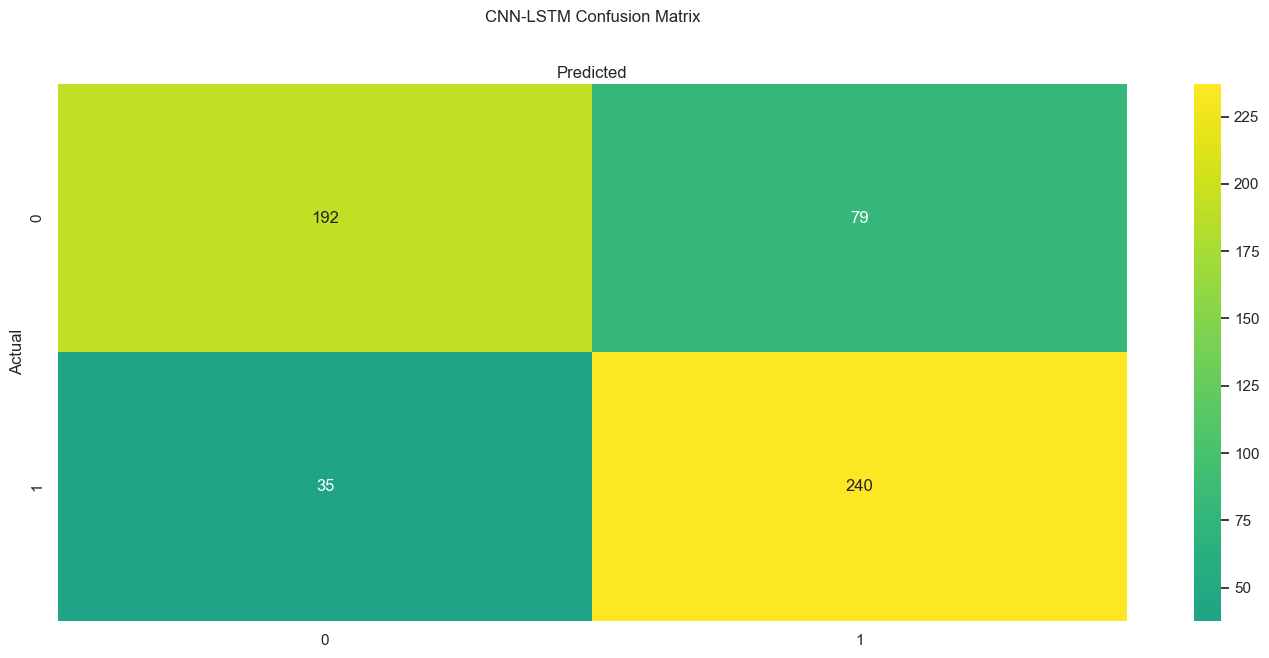

In [32]:
nn_confusion_matrix = confusion_matrix(y_test, y_pred)

class_names=["0", "1"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(nn_confusion_matrix), annot=True, cmap="viridis" ,fmt='g', robust=True, center=0,
           xticklabels=["0", "1"], yticklabels=['0', '1'])
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CNN-LSTM Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted');

### Summary and Implications
In this project, three different models were utilized for sentiment analysis: logistic regression, random forest regression, and CNN-LSTM. Each model demonstrated varying levels of performance and effectiveness in predicting sentiment.

The logistic regression model achieved an accuracy of 0.7967 on the test data, with precision and recall scores of 0.7887 and 0.8145, respectively. The F1-score for this model was 0.8014, indicating a good balance between precision and recall. The logistic regression model also had an RMSE of 0.4509 and an MSE of 0.2033, suggesting that its predictions were relatively close to the true values. The log loss value for this model was 7.3276, and the AUC-ROC score was 0.7966.

The random forest regression model achieved an accuracy of 0.7491 on the test data, with precision and recall scores of 0.7396 and 0.7745, respectively. The F1-score for this model was 0.7567, indicating a reasonable balance between precision and recall. The random forest model had a test set RMSE of 0.4109 and a test set MSE of 0.1688, suggesting relatively accurate predictions. The log loss value for this model was 9.0439, and the AUC-ROC score was 0.7489.

The CNN-LSTM model achieved an accuracy of 0.8132 on the test data. The precision and recall scores for this model were 0.85 and 0.71, respectively, resulting in an F1-score of 0.77. The test set RMSE for the CNN-LSTM model was not calculated, but the model had a test loss of 0.4320. The AUC-ROC score for this model was not provided.

Comparing the three models, the logistic regression model demonstrated good performance with balanced precision and recall scores. The random forest regression model achieved reasonable accuracy and F1-score, while the CNN-LSTM model showed promising accuracy but lower precision and recall compared to the other models.

Overall, each model exhibited strengths and weaknesses in predicting sentiment. The logistic regression model showcased balanced performance, the random forest regression model demonstrated reasonable accuracy, and the CNN-LSTM model showed potential for high accuracy.

Based on these results, it can be inferred that training the CNN-LSTM model on a larger dataset or providing it with more data would likely result in a model that is capable of achieving both high accuracy and high performance in sentiment analysis. This suggests that the CNN-LSTM model has the potential for further improvement and can benefit from additional training data to enhance its predictive capabilities. 

## Reference

Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., Corrado, G. S., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I., Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia, Y., Kaiser, L., Kudlur, M., … Zheng, X. (2015). TensorFlow: Large-scale machine learning on heterogeneous systems. TensorFlow. Retrieved from https://www.tensorflow.org/ 

Chakure, A. (2020, November 06). Random Forest and Its Implementation. Retrieved from https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f

Feature Engineering for NLP in Python. (n.d.). DataCamp. Retrieved January 18, 2022, from https://app.datacamp.com/learn/courses/feature-engineering-for-nlp-in-python

Google. (n.d.). Classification: Precision and recall | machine learning crash course | google developers. Google. Retrieved May 17, 2022, from https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

Introduction to Deep Learning with Keras. (n.d.). DataCamp. Retrieved February 20, 2022, from https://app.datacamp.com/learn/courses/introduction-to-deep-learning-with-keras

K, G. M. (2020, July 18). Machine Learning Basics: Random Forest Regression. Retrieved from https://towardsdatascience.com/machine-learning-basics-random-forest-regression-be3e1e3bb91a

Kotzias, D., Denil, M., De Freitas, N., & Smyth, P. (2015). From Group to Individual Labels using Deep Features. In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.

Kumar, S. (2021, July 14). Top 5 business use cases of sentiment analysis. An Indium Software Company. Retrieved March 2, 2022, from https://www.tex-ai.com/top-5-use-cases-of-sentiment-analysis/

Leung, K. (2022, January 9). Micro, Macro & weighted averages of F1 score, clearly explained. Medium. Retrieved May 17, 2022, from https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

Machine Learning with Tree-Based Models in Python. (n.d.). Retrieved from https://learn.datacamp.com/courses/machine-learning-with-tree-based-models-in-python

Pedregosa et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research. Retrieved May 17, 2022, from https://jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf

Pierson, L. (2019, October 24). Retrieved from https://www.linkedin.com/learning/python-for-data-science-essential-training-part-1/

Pierson, L. (2019, October 25). Retrieved from https://www.linkedin.com/learning/python-for-data-science-essential-training-part-2/

Prosise, J. (2021, October 4). Text classification with Neural Networks. Atmosera. Retrieved February 20, 2022, from https://www.atmosera.com/blog/text-classification-with-neural-networks/

Python Logistic Regression with Sklearn & Scikit. (n.d.). Retrieved from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

Text classification with an RNN:  Tensorflow. TensorFlow. (n.d.). Retrieved February 20, 2022, from https://www.tensorflow.org/text/tutorials/text_classification_rnn 

Wood, T. (2019, May 17). F-score. DeepAI. Retrieved May 17, 2022, from https://deepai.org/machine-learning-glossary-and-terms/f-score

Wong, A. (2020, April 05). Random Forest Deep Dive & Beyond - ML for coders by Fast.ai (Lesson 2). Retrieved from https://medium.com/analytics-vidhya/random-forest-deep-dive-beyond-ml-for-coders-by-fast-ai-lesson-2-72c509900bab